In [10]:
from neuron import h, gui
from neuron.units import mV, ms
import matplotlib.pyplot as plt

In [11]:
treeA_datas = [(0, -1, 1, 3.180, 10, 123),
              (1, 0, 1, 3.280, 9.8, 123),
              (2, 0, 1, 3.080, 9.3, 123),
              (3, 1, 1, 3.150, 11, 123),
              (4, 1, 1, 3.30, 6, 123),
              (5, 2, 1, 3.10, 8, 123),
              (6, 2, 1, 4.180, 8.8, 123),
              (7, 3, 1, 4.180, 8.8, 123),
              (8, 5, 1, 4.180, 8.8, 123)]

treeB_datas = [(0, -1, 1, 3.180, 10, 123),
              (1, 0, 1, 3.180, 10, 123),
              (2, 0, 1, 3.180, 10, 123),
              (3, 1, 1, 3.180, 10, 123),
              (4, 1, 1, 3.180, 10, 123),
              (5, 2, 1, 3.180, 10, 123),
              (6, 2, 1, 3.180, 10, 123),
              (7, 6, 1, 3.180, 10, 123),
              (8, 6, 1, 3.180, 10, 123),
              (9, 4, 1, 3.180, 10, 123)]

In [12]:
class SThcell:
    name = "Cell"
    
    def __init__(self, gid):
        self.treeA = {}
        self.treeB = {}
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
        self._make_treeA()
        self._make_treeB()
        self.all = self.soma.wholetree()
        
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.soma.nseg = 1
        self.soma.diam = 18.8
        self.soma.L = 18.8
        self.soma.Ra = 123
        
    def _setup_biophysics(self):
        self.soma.insert('hh')
        for seg in self.soma:
            seg.hh.gnabar = 0.25
            seg.hh.gl = 0.0001666
            seg.hh.el = -60
    
    def _make_treeA(self):
        for treeA_data in treeA_datas:
            me = treeA_data[0]
            parent = treeA_data[1]
            
            self.treeA[me] = h.Section(name='branch', cell=self)

            self.treeA[me].nseg = treeA_data[2]
            self.treeA[me].diam = treeA_data[3]
            self.treeA[me].L = treeA_data[4]
            self.treeA[me].Ra = treeA_data[5]
            
            self.treeA[me].insert('pas')
            for seg in self.treeA[me]:
                seg.pas.g = 0.0001666
                seg.pas.e = -60.0 
            
            if parent >= 0: 
                self.treeA[me].connect(self.treeA[parent], 1, 0)
                
        self.treeA[0].connect(self.soma, 0, 0)
    
    def _make_treeB(self):
        for treeB_data in treeB_datas:
            me = treeB_data[0]
            parent = treeB_data[1]
            
            self.treeB[me] = h.Section(name='branch', cell=self)

            self.treeB[me].nseg = treeB_data[2]
            self.treeB[me].diam = treeB_data[3]
            self.treeB[me].L = treeB_data[4]
            self.treeB[me].Ra = treeB_data[5]
            
            self.treeB[me].insert('pas')
            for seg in self.treeB[me]:
                seg.pas.g = 0.0001666
                seg.pas.e = -60.0 
            
            if parent >= 0: 
                self.treeB[me].connect(self.treeB[parent], 1, 0)
                
        self.treeB[0].connect(self.soma, 1, 0)
        
    def _set_position(self):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(i, sec.x3d(i), sec.y3d(i), sec.z3d(i), sec.diam3d(i))
                
    def _rotate(self):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(i, 15, 15, sec.z3d(i), sec.diam3d(i))
    
    def __repr__(self):
        return f'{self.name}[{self._gid}]'

In [13]:
nSThcells = 4
SThcells = [SThcell(i) for i in range(nSThcells)]

In [14]:
ps = h.PlotShape(True)
ps.show(0)

1.0

In [15]:
stim = []
for i in range(nSThcells):
    stim.append(h.IClamp(SThcells[i].soma(0.5)))
    stim[i].delay = 50
    stim[i].dur = 100
    stim[i].amp = 0.1

In [16]:
soma_vs = []
for i in range(nSThcells):
    soma_vs.append(h.Vector().record(SThcells[i].soma(0.5)._ref_v))
stim_v = h.Vector().record(stim[0]._ref_i)
t = h.Vector().record(h._ref_t)

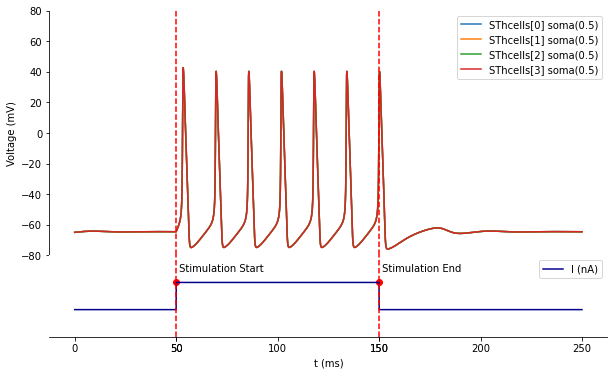

In [17]:
h.tstop = 250
h.v_init = -65
h.run()

f, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]}, figsize=(10, 6))

for i, soma_v in enumerate(soma_vs):
    ax0.plot(t, soma_v, label=f'SThcells[{i}] soma(0.5)')
ax1.plot(t, stim_v, 'darkblue', label='I (nA)')

ax0.set_ylabel('Voltage (mV)')
ax0.set_ylim(-80,80)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.get_xaxis().set_visible(False)
ax0.legend()

ax1.set_ylabel('I (nA)')
ax1.set_xlabel('t (ms)')
ax1.set_ylim(-0.1, 0.2)
ax1.set_xticks(sorted([i for i in range(0, int(h.tstop)+10, 50)]+[int(stim[0].delay), int(stim[0].delay+stim[0].dur)]))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.legend()


ax1.text(stim[0].delay, stim[0].amp+0.04, " Stimulation Start", ha='left')
ax1.text(stim[0].delay+stim[0].dur, stim[0].amp+0.04, " Stimulation End", ha='left')
ax1.scatter(stim[0].delay, stim[0].amp, color='red')
ax1.scatter(stim[0].delay+stim[0].dur, stim[0].amp, color='red')
ax0.axvline(stim[0].delay, color='red', linestyle="dashed")
ax0.axvline(stim[0].delay+stim[0].dur, color='red', linestyle="dashed")
ax1.axvline(stim[0].delay, color='red', linestyle="dashed")
ax1.axvline(stim[0].delay+stim[0].dur, color='red', linestyle="dashed")

plt.subplots_adjust(hspace=0)

plt.show()

In [18]:
stim = h.IClamp(SThcells[0].soma(0.5))
stim.delay = 50
stim.dur = 100
stim.amp = 0.1

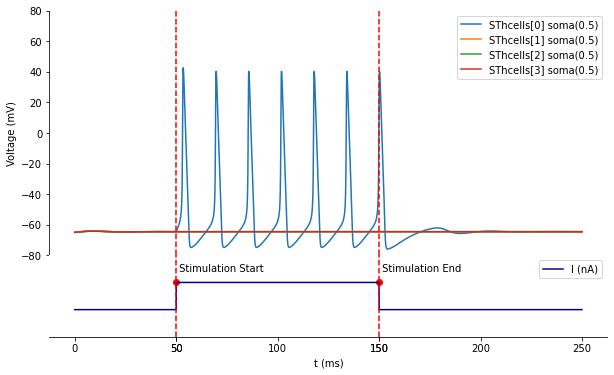

In [22]:
h.tstop = 250
h.v_init = -65
h.run()

f, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]}, figsize=(10, 6))

for i, soma_v in enumerate(soma_vs):
    ax0.plot(t, soma_v, label=f'SThcells[{i}] soma(0.5)')
ax1.plot(t, stim_v, 'darkblue', label='I (nA)')

ax0.set_ylabel('Voltage (mV)')
ax0.set_ylim(-80,80)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.get_xaxis().set_visible(False)
ax0.legend()

ax1.set_ylabel('I (nA)')
ax1.set_xlabel('t (ms)')
ax1.set_ylim(-0.1, 0.2)
ax1.set_xticks(sorted([i for i in range(0, int(h.tstop)+10, 50)]+[int(stim.delay), int(stim.delay+stim.dur)]))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.legend()


ax1.text(stim.delay, stim.amp+0.04, " Stimulation Start", ha='left')
ax1.text(stim.delay+stim.dur, stim.amp+0.04, " Stimulation End", ha='left')
ax1.scatter(stim.delay, stim.amp, color='red')
ax1.scatter(stim.delay+stim.dur, stim.amp, color='red')
ax0.axvline(stim.delay, color='red', linestyle="dashed")
ax0.axvline(stim.delay+stim.dur, color='red', linestyle="dashed")
ax1.axvline(stim.delay, color='red', linestyle="dashed")
ax1.axvline(stim.delay+stim.dur, color='red', linestyle="dashed")

plt.subplots_adjust(hspace=0)

plt.show()

In [27]:
syns = []
netcons = []
for source, target in zip(SThcells, SThcells[1:] + [SThcells[0]]):
    syn = h.ExpSyn(target.treeB[treeB_datas[-1][0]](0.5))
    nc = h.NetCon(source.soma(0.5)._ref_v, syn, sec=source.soma)
    nc.threshold = -20 * mV
    nc.weight[0] = 0.5
    nc.delay = 1 * ms
    netcons.append(nc)
    syns.append(syn)

In [10]:
stim = h.IClamp(SThcells[0].soma(0.5))
stim.delay = 50
stim.dur = 100
stim.amp = 0.1

In [11]:
soma_vs = []
for i in range(nSThcells):
    soma_vs.append(h.Vector().record(SThcells[i].soma(0.5)._ref_v))
stim_v = h.Vector().record(stim._ref_i)
t = h.Vector().record(h._ref_t)

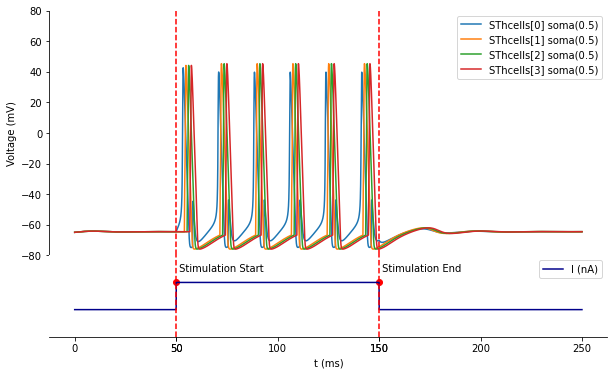

In [12]:
h.tstop = 250
h.v_init = -65
h.run()

f, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]}, figsize=(10, 6))

for i, soma_v in enumerate(soma_vs):
    ax0.plot(t, soma_v, label=f'SThcells[{i}] soma(0.5)')
ax1.plot(t, stim_v, 'darkblue', label='I (nA)')

ax0.set_ylabel('Voltage (mV)')
ax0.set_ylim(-80,80)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.get_xaxis().set_visible(False)
ax0.legend()

ax1.set_ylabel('I (nA)')
ax1.set_xlabel('t (ms)')
ax1.set_ylim(-0.1, 0.2)
ax1.set_xticks(sorted([i for i in range(0, int(h.tstop)+10, 50)]+[int(stim.delay), int(stim.delay+stim.dur)]))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.legend()


ax1.text(stim.delay, stim.amp+0.04, " Stimulation Start", ha='left')
ax1.text(stim.delay+stim.dur, stim.amp+0.04, " Stimulation End", ha='left')
ax1.scatter(stim.delay, stim.amp, color='red')
ax1.scatter(stim.delay+stim.dur, stim.amp, color='red')
ax0.axvline(stim.delay, color='red', linestyle="dashed")
ax0.axvline(stim.delay+stim.dur, color='red', linestyle="dashed")
ax1.axvline(stim.delay, color='red', linestyle="dashed")
ax1.axvline(stim.delay+stim.dur, color='red', linestyle="dashed")

plt.subplots_adjust(hspace=0)

plt.show()

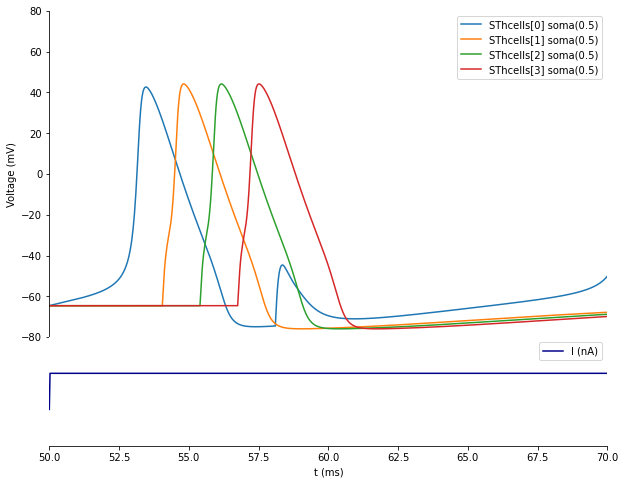

In [13]:
h.tstop = 250
h.v_init = -65
h.run()

f, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]}, figsize=(10, 8))

for i, soma_v in enumerate(soma_vs):
    ax0.plot(t, soma_v, label=f'SThcells[{i}] soma(0.5)')
ax1.plot(t, stim_v, 'darkblue', label='I (nA)')

ax0.set_ylabel('Voltage (mV)')
ax0.set_xlim(50, 70)
ax0.set_ylim(-80,80)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.get_xaxis().set_visible(False)
ax0.legend()


ax1.set_ylabel('I (nA)')
ax1.set_xlabel('t (ms)')
ax1.set_xlim(50, 70)
ax1.set_ylim(-0.1, 0.2)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.legend()



# ax1.text(stim.delay, stim.amp+0.04, " Stimulation Start", ha='left')
# ax1.text(stim.delay+stim.dur, stim.amp+0.04, " Stimulation End", ha='left')
# ax1.scatter(stim.delay, stim.amp, color='red')
# ax1.scatter(stim.delay+stim.dur, stim.amp, color='red')
# ax0.axvline(stim.delay, color='red', linestyle="dashed")
# ax0.axvline(stim.delay+stim.dur, color='red', linestyle="dashed")
# ax1.axvline(stim.delay, color='red', linestyle="dashed")
# ax1.axvline(stim.delay+stim.dur, color='red', linestyle="dashed")

plt.subplots_adjust(hspace=0)

plt.show()

In [23]:
ps = h.PlotShape(True)
ps.show(0)

1.0